# RAINFALL PREDICTION IN INDIA

Our goal is to analyse Daily rainfall data-India(2009-2024) and predict the rainfall in different states of india for the next 6 years

In [23]:
# The dataset includes:

# Actual, forecasted, and normal rainfall values
# Deviation-Percent deviation from normal rainfall
# State-level granularity across 28 states and 8 union territories
# Over 200,000 observations in total 

## 1.Load and Clean Data

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Import libraries
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
# Load dataset
df = pd.read_csv('daily-rainfall-at-state-level (1).csv')
df.head()

,id,date,state_code,state_name,actual,rfs,normal,deviation
0,0,2009-01-01,5,Uttarakhand,0.0,0.003906,2.19,-100.0
1,1,2009-01-01,18,Assam,0.0,0.000000,0.52,-100.0
2,2,2009-01-01,16,Tripura,0.0,0.000000,0.09,-100.0
3,3,2009-01-01,36,Telangana,0.0,0.000000,0.17,-100.0
4,4,2009-01-01,2,Himachal Pradesh,0.0,0.008566,3.31,-100.0


In [27]:
df.shape

(204876, 8)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204876 entries, 0 to 204875
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          204876 non-null  int64  
 1   date        204876 non-null  object 
 2   state_code  204876 non-null  int64  
 3   state_name  204876 non-null  object 
 4   actual      187714 non-null  float64
 5   rfs         199011 non-null  float64
 6   normal      193358 non-null  float64
 7   deviation   173855 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 12.5+ MB


In [29]:
df.isna().sum()

id                0
date              0
state_code        0
state_name        0
actual        17162
rfs            5865
normal        11518
deviation     31021
dtype: int64

In [30]:
# Drop missing values
df.dropna(inplace=True)

In [31]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

## 2.SimpleRNN MODEL CREATION

In [32]:

# Function to train a SimpleRNN model for one state and forecast
def train_and_forecast_state(df_state, n_input=12, n_forecast=81, epochs=20, save_dir="models"):
    
    # Training a SimpleRNN model for a single state's rainfall data and forecast future rainfall.

    # Parameters:
    # df_state  : DataFrame containing 'date', 'actual', and 'state_name'
    # n_input   : Number of months in input sequence for prediction
    # n_forecast: Months to forecast ahead
    # epochs    : Training epochs
    # save_dir  : Folder to save the trained model
    

    # 1️ Aggregate daily to monthly rainfall
    df_monthly = df_state.groupby(pd.Grouper(key='date', freq='MS'))['actual'].sum().reset_index()
    df_monthly['state_name'] = df_state['state_name'].iloc[0]

    # 2️ Prepare data for scaling
    rain_values = df_monthly['actual'].values.astype('float32').reshape(-1, 1)

    # 3️ Train-test split (90% train, 10% test)
    train_size = int(len(rain_values) * 0.9)
    train = rain_values[:train_size]
    test = rain_values[train_size:]

    # 4️ Scale values between 0 and 1
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # 5️ Prepare generator for training
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

    # 6️ Build SimpleRNN model
    model = Sequential([
        SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(n_input, 1)),
        Dropout(0.2),
        SimpleRNN(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # 7️ Train model
    model.fit(train_generator, epochs=epochs, verbose=0)

    # 8️ test prediction
    test_predictions = []
    test_input = train_scaled[-n_input:]  # last part of train as starting point
    for i in range(len(test_scaled)):
        pred = model.predict(test_input.reshape((1, n_input, 1)), verbose=0)[0]
        test_predictions.append(pred)
        test_input = np.append(test_input[1:], [test_scaled[i]], axis=0)

    # 9️ Inverse transform to original scale
    test_predictions = scaler.inverse_transform(test_predictions)
    test_actual = rain_values[train_size:]

    #  10 Metrics
    rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
    mae = mean_absolute_error(test_actual, test_predictions)
    R2_score = r2_score(test_actual, test_predictions) * 100

    # 11 Forecast future
    scaled_values = scaler.transform(rain_values)
    last_sequence = scaled_values[-n_input:]
    current_batch = last_sequence.reshape((1, n_input, 1))
    future_predictions_scaled = []

    for i in range(n_forecast):
        next_pred = model.predict(current_batch, verbose=0)[0]
        future_predictions_scaled.append(next_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[next_pred]], axis=1)

    future_predictions_scaled = np.array(future_predictions_scaled)
    future_predictions = scaler.inverse_transform(future_predictions_scaled)

    # 1️2 Create future dates
    last_date = df_monthly['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=n_forecast, freq='MS')

    forecast_df = pd.DataFrame({
        'date': future_dates,
        'state_name': df_monthly['state_name'].iloc[0],
        'predicted_rainfall': future_predictions.flatten()
    })

    # 1️3 Save model
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{df_monthly['state_name'].iloc[0]}.h5")
    model.save(model_path)

    return forecast_df, rmse, mae, R2_score, df_monthly, test_predictions, test_actual

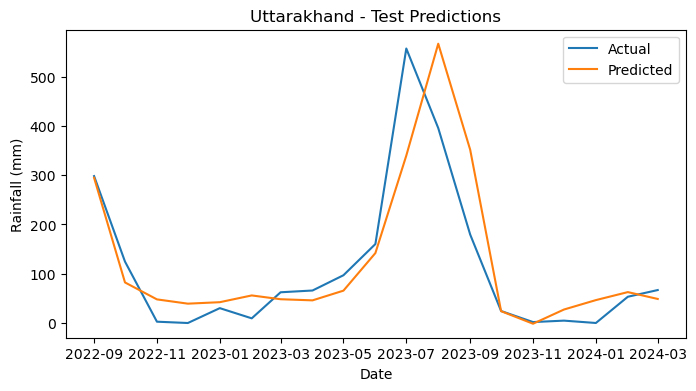

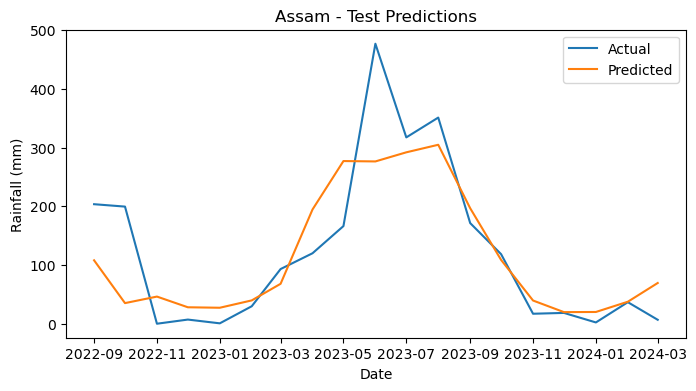

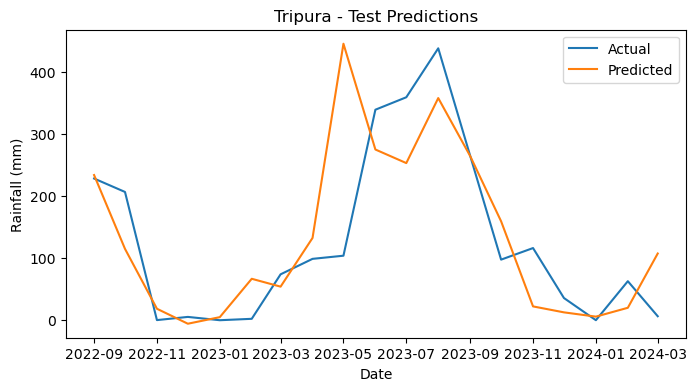

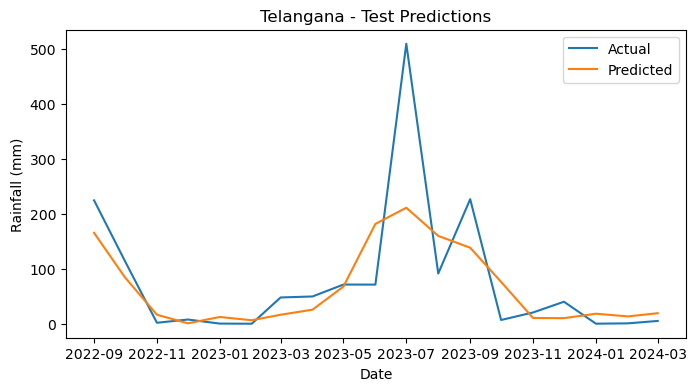

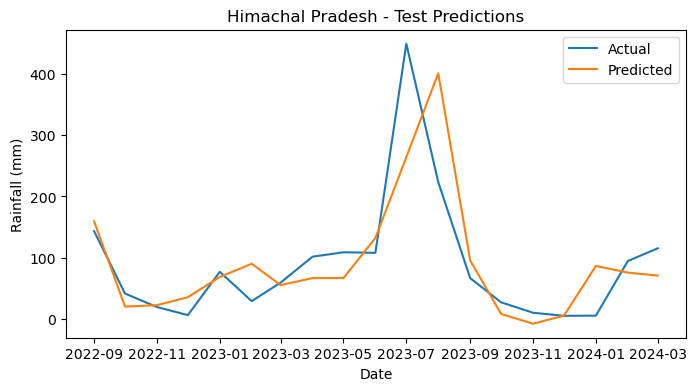

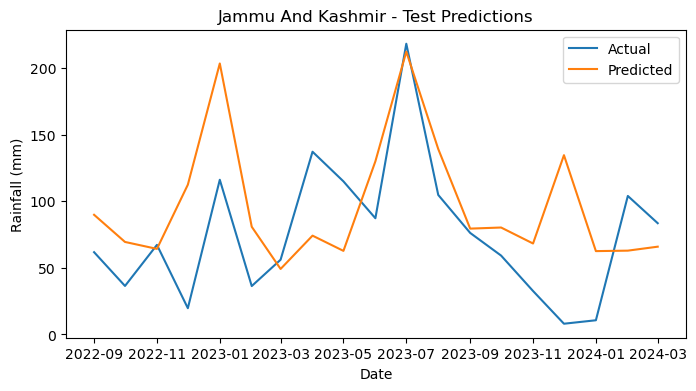

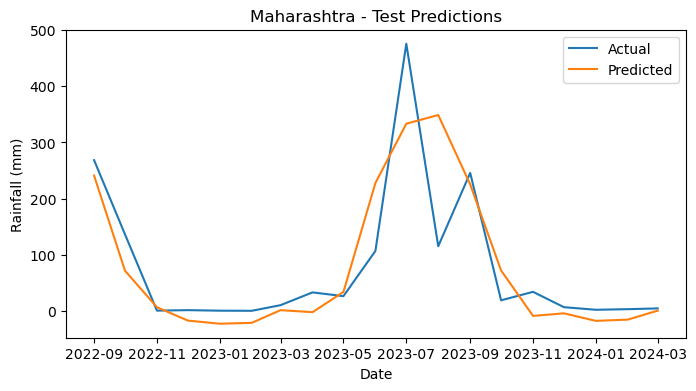

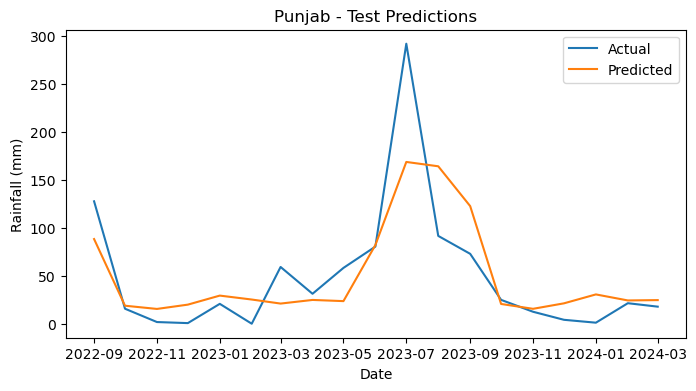

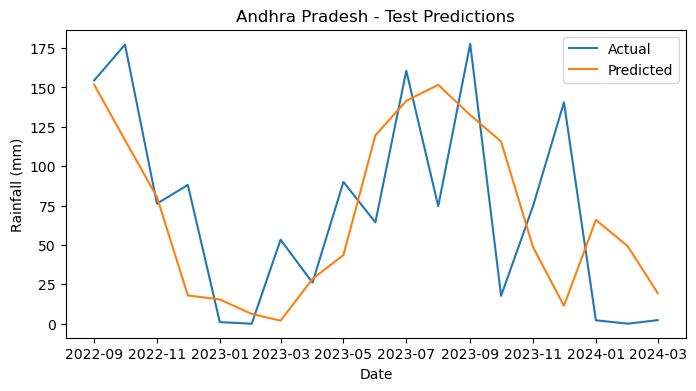

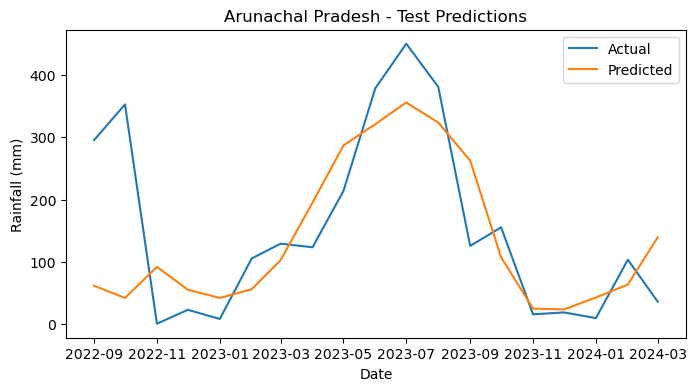

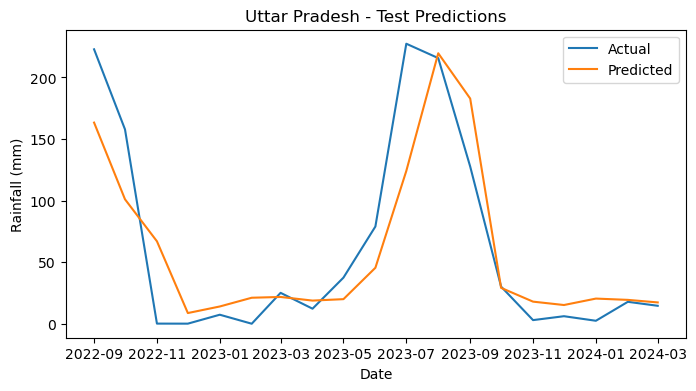

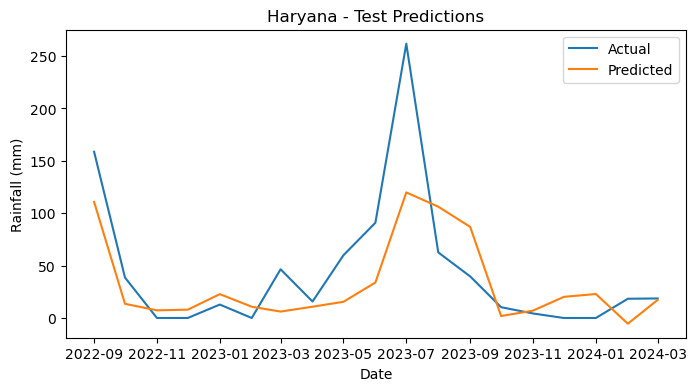

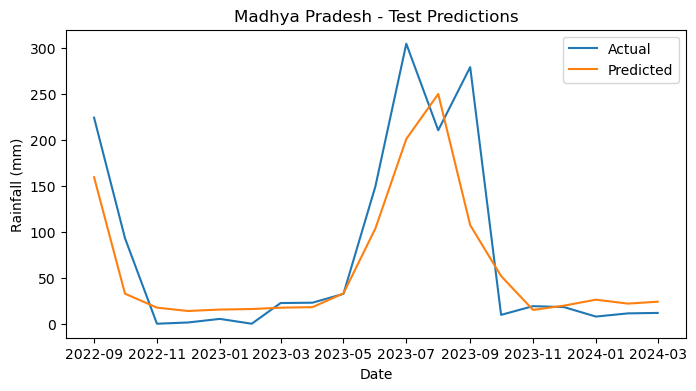

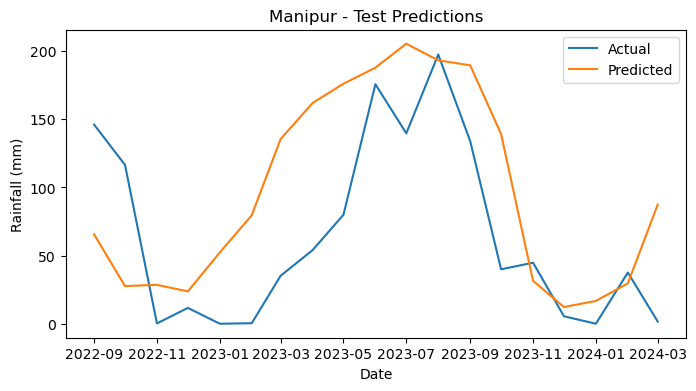

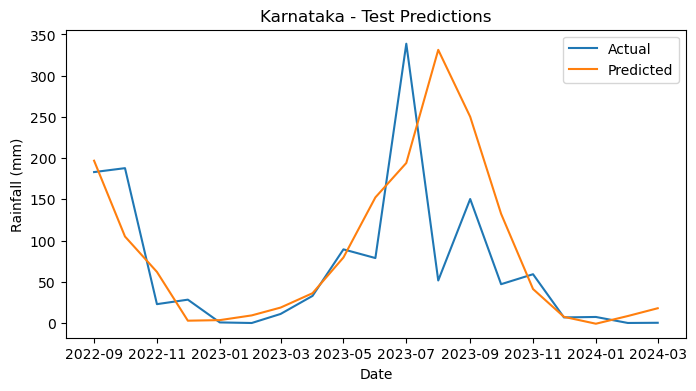

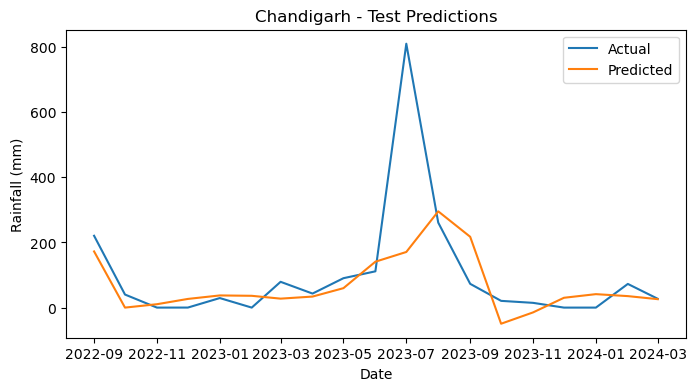

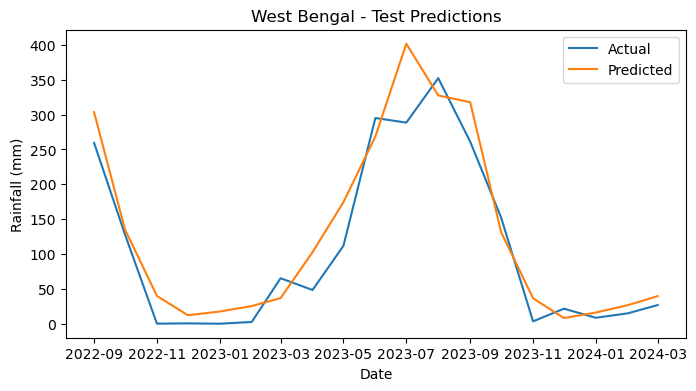

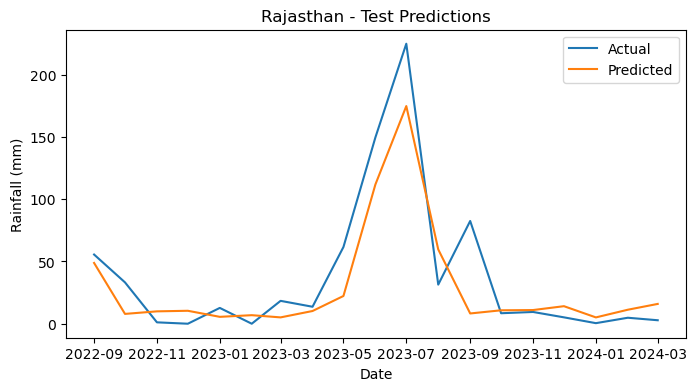

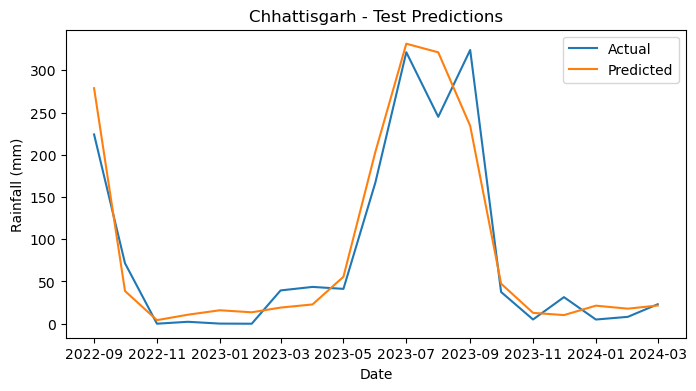

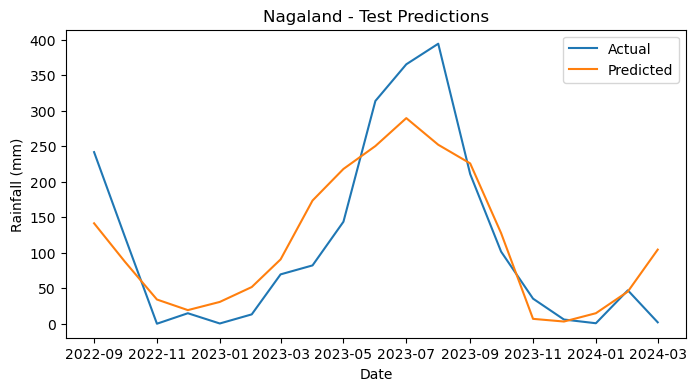

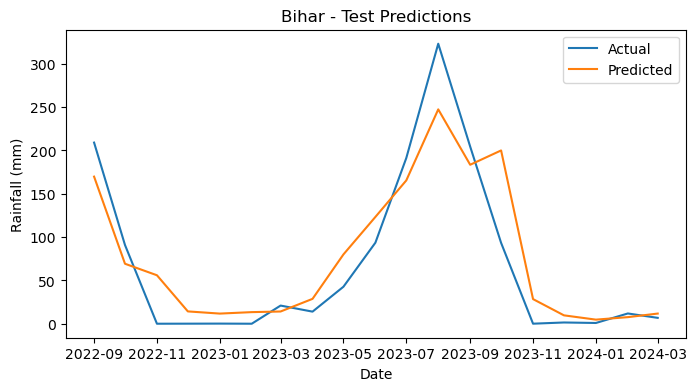

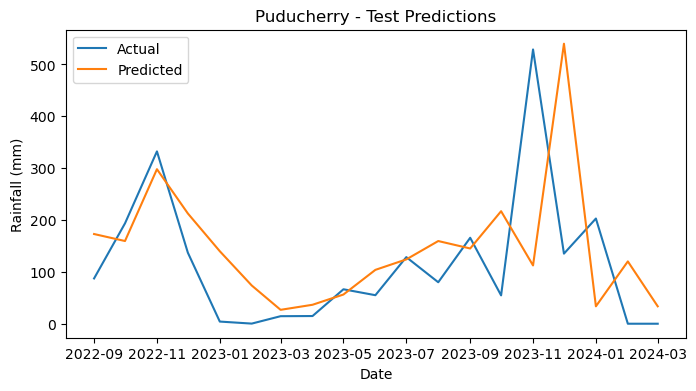

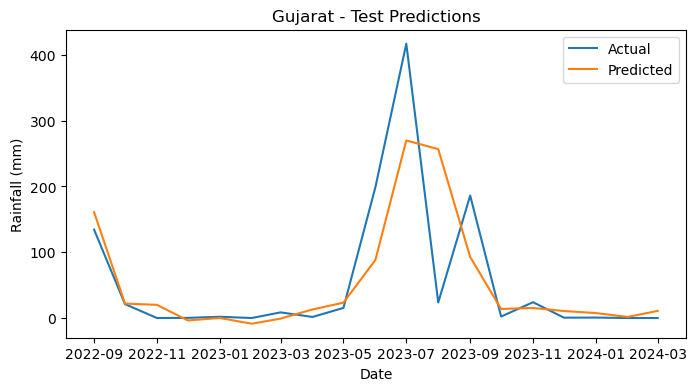

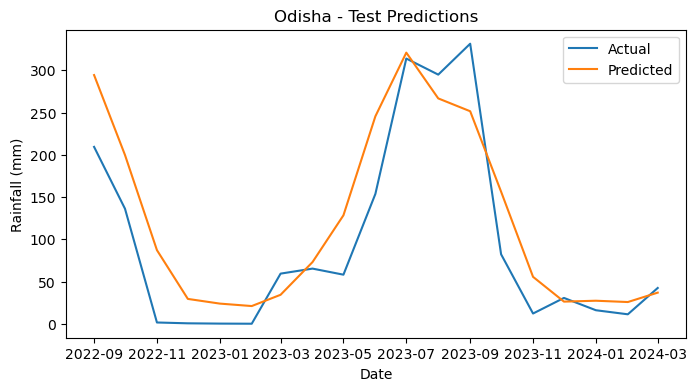

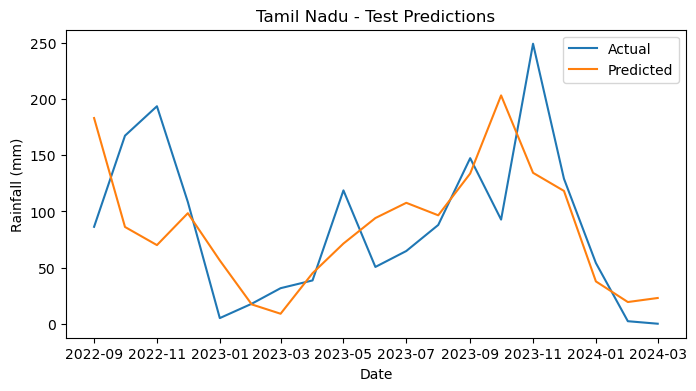

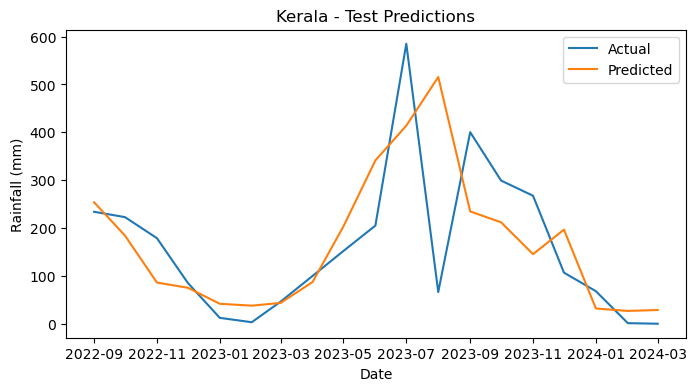

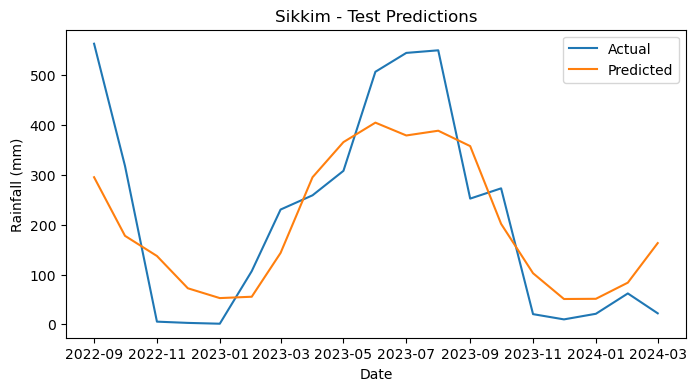

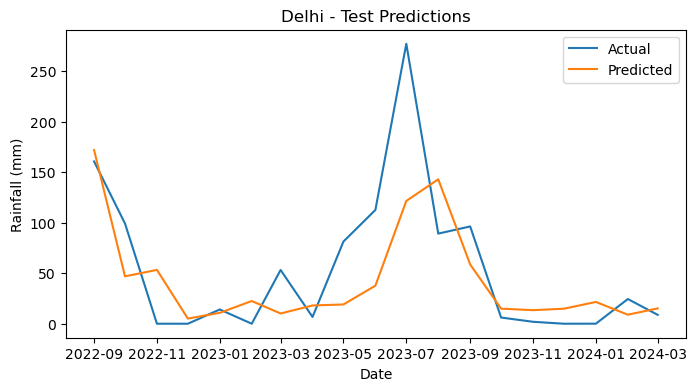

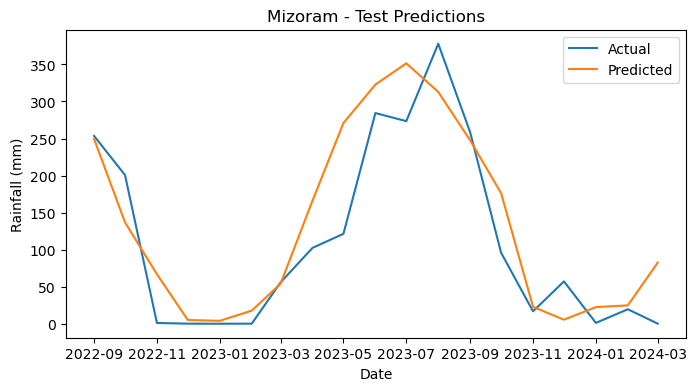

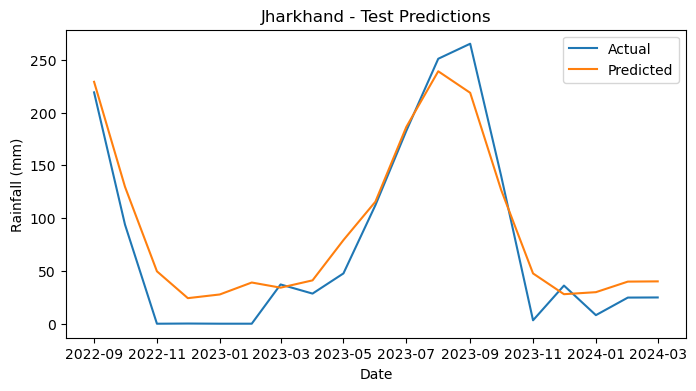

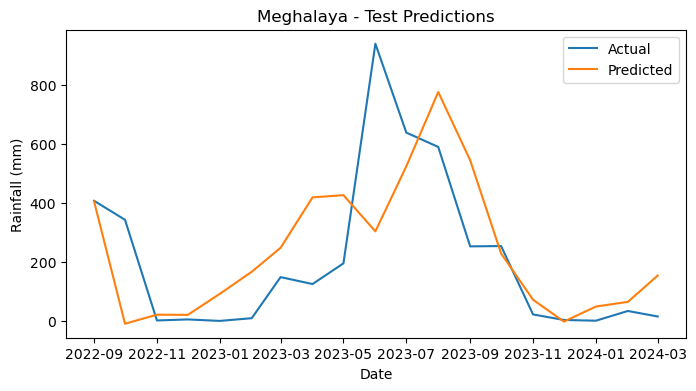

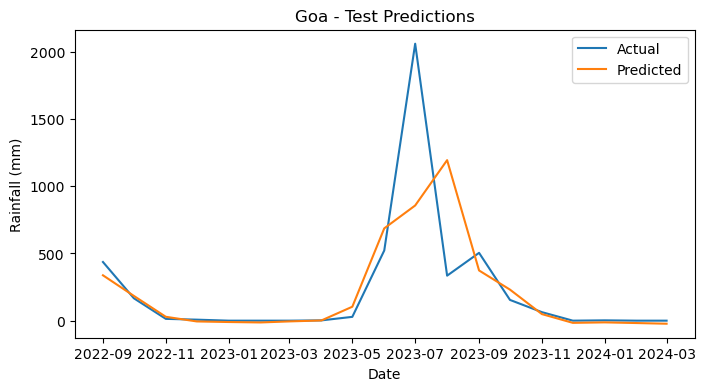

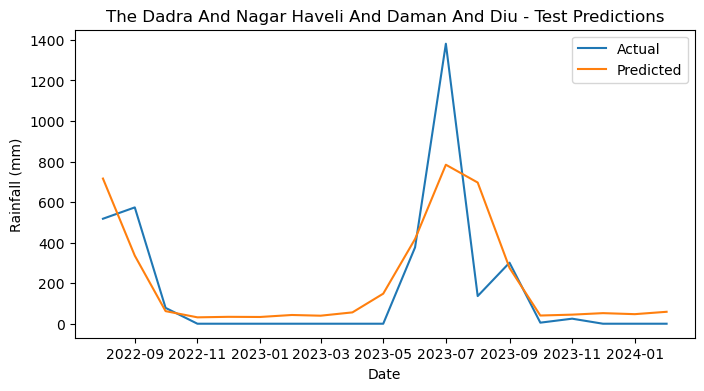

                                           state        RMSE         MAE  \
0                                    Uttarakhand   79.026720   49.080150   
1                                          Assam   74.844015   51.915357   
2                                        Tripura   96.888782   61.601467   
3                                      Telangana   81.511753   47.678498   
4                               Himachal Pradesh   67.023606   43.088263   
5                              Jammu And Kashmir   52.476181   41.637307   
6                                    Maharashtra   73.753895   46.352230   
7                                         Punjab   39.557000   26.293750   
8                                 Andhra Pradesh   55.592653   44.088392   
9                              Arunachal Pradesh  108.907504   79.301219   
10                                 Uttar Pradesh   38.141646   25.796127   
11                                       Haryana   43.508376   29.876465   
12          

In [33]:
all_states = df['state_name'].unique()
forecast_list = []
metrics_list = []

for state in all_states:
    df_state = df[df['state_name'] == state]
    forecast_df, rmse, mae, R2, monthly_data, test_preds, test_actuals = train_and_forecast_state(df_state)

    forecast_list.append(forecast_df)
    metrics_list.append({'state': state, 'RMSE': rmse, 'MAE': mae, 'R2_score': R2})

    # Plot actual vs predicted (test period only)
    plt.figure(figsize=(8,4))
    plt.plot(monthly_data['date'][-len(test_actuals):], test_actuals, label="Actual")
    plt.plot(monthly_data['date'][-len(test_actuals):], test_preds, label="Predicted")
    plt.title(f"{state} - Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.show()

# Combine results
forecast_results = pd.concat(forecast_list, ignore_index=True)
metrics_df = pd.DataFrame(metrics_list)

print(metrics_df)

# Save to CSV
forecast_results.to_csv('forecast_results.csv', index=False)
metrics_df.to_csv('model_metrics.csv', index=False)